In [3]:
import os
for dirname, _, filenames in os.walk('D:\Amro\AUC_final_semester\Embedded\project'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

D:\Amro\AUC_final_semester\Embedded\project\100.dat
D:\Amro\AUC_final_semester\Embedded\project\mitbih_test.csv
D:\Amro\AUC_final_semester\Embedded\project\mitbih_test.csv.zip
D:\Amro\AUC_final_semester\Embedded\project\mitbih_train.csv
D:\Amro\AUC_final_semester\Embedded\project\mitbih_train.csv.zip
D:\Amro\AUC_final_semester\Embedded\project\Untitled.ipynb
D:\Amro\AUC_final_semester\Embedded\project\.ipynb_checkpoints\Untitled-checkpoint.ipynb


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [6]:
train_df=pd.read_csv('D:\Amro\AUC_final_semester\Embedded\project\mitbih_train.csv',header=None)
test_df=pd.read_csv('D:\Amro\AUC_final_semester\Embedded\project\mitbih_test.csv',header=None)

In [7]:
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()
print(equilibre)

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


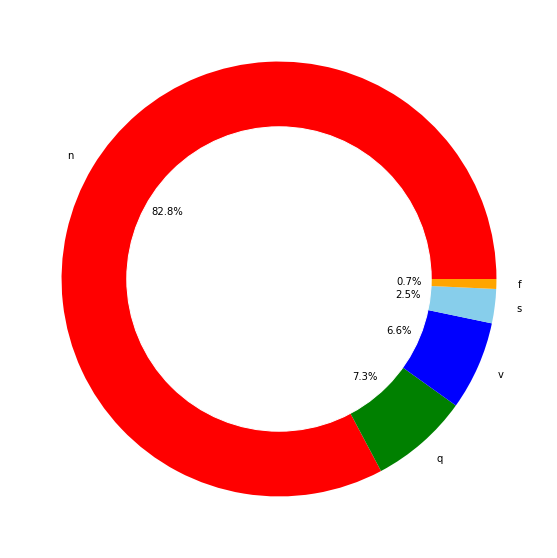

In [8]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [9]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [10]:
equilibre=train_df[187].value_counts()
print(equilibre)

4    20000
3    20000
2    20000
1    20000
0    20000
Name: 187, dtype: int64


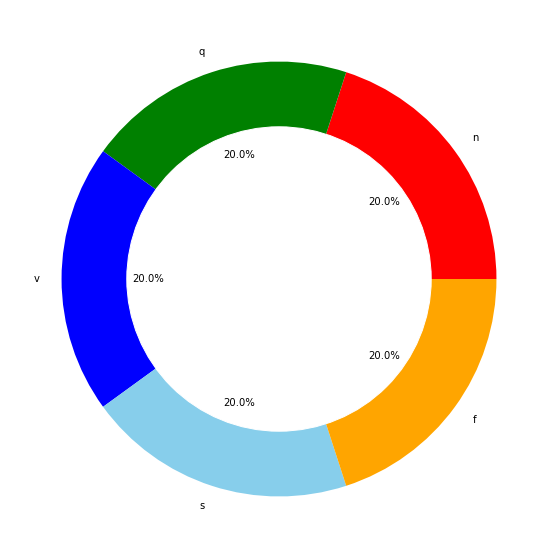

In [11]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [12]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.05,186)
    return (signal+noise)

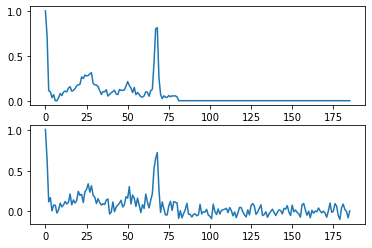

In [13]:
c=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))

tempo=c.iloc[0,:186]
bruiter=add_gaussian_noise(tempo)

plt.subplot(2,1,1)
plt.plot(c.iloc[0,:186])

plt.subplot(2,1,2)
plt.plot(bruiter)

plt.show()

In [14]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)


In [15]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
#for i in range(len(X_train)):
#    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [19]:
def network(X_train,y_train,X_test,y_test):
    

    data_input=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='data_input')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='CNN_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=5,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('CNN_model.h5')
    return(model,history)

In [17]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

In [20]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

model,history=network(X_train,y_train,X_test,y_test)

Train on 100000 samples, validate on 21892 samples
Epoch 1/5
100000/100000 [==============================] - 105s 1ms/step - loss: 0.1814 - accuracy: 0.9365 - val_loss: 0.3189 - val_accuracy: 0.8874
Epoch 2/5
100000/100000 [==============================] - 106s 1ms/step - loss: 0.0696 - accuracy: 0.9761 - val_loss: 0.1490 - val_accuracy: 0.9524
Epoch 3/5
100000/100000 [==============================] - 109s 1ms/step - loss: 0.0476 - accuracy: 0.9841 - val_loss: 0.1391 - val_accuracy: 0.9582
Epoch 4/5
100000/100000 [==============================] - 109s 1ms/step - loss: 0.0344 - accuracy: 0.9890 - val_loss: 0.1157 - val_accuracy: 0.9678
Epoch 5/5
100000/100000 [==============================] - 108s 1ms/step - loss: 0.0273 - accuracy: 0.9915 - val_loss: 0.1277 - val_accuracy: 0.9681


Accuracy: 96.78%


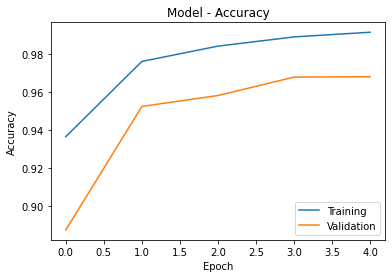

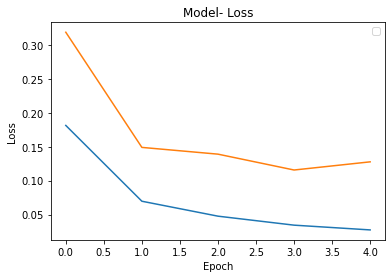

In [21]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

Normalized confusion matrix


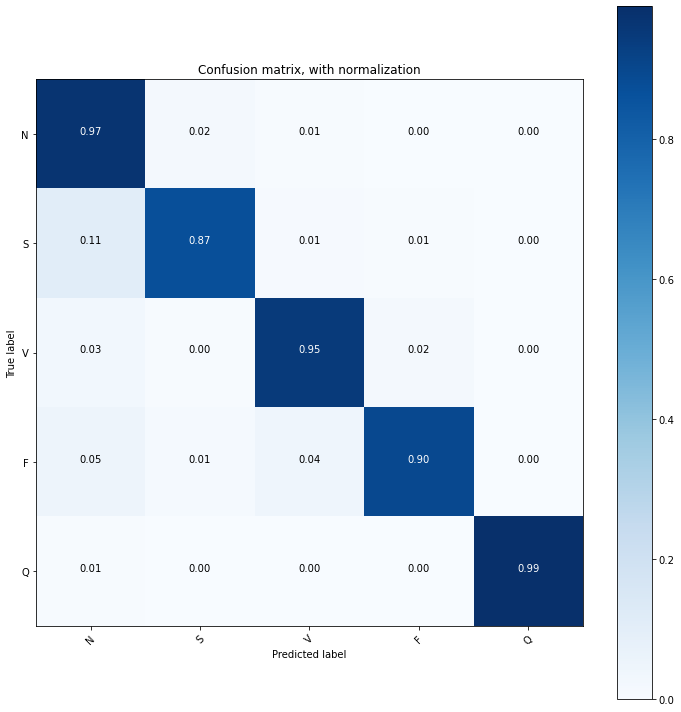

In [22]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()